## Lab 7 (Image Processing using Convolutional Neural Networks)
- CIFAR10 dataset (see https://www.cs.toronto.edu/~kriz/cifar.html for more info)
- 60K images: 50K train, 10K test
- 10 classes: 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- Perform multi-class classification with evaluation accuracy on EACH class

**CONNECT TO GPU** before continuing, but just CPU is also fine, it might be a bit slow.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyper parameters
num_epochs = 4
batch_size = 4
learning_rate = 0.001

# Download and prepare dataset
# Transform them to tensors and normalise them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

# 2.2 Download data
train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

# 2.3 Use DataLoader to get batches and shuffle
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Q1. Why are there 3 values in each list of the Normalize() function? What does each value and each list represent?
# Each of the three input list means mean list, standard deviation list. 
# Since the given image tensor has three channels(shape.images : 4, 3, 32, 32, the '3' means number of channels of tensor), 
# the average value and standard deviation value required for applying normalization to each channel were entered in the form of a list with three elements.
# From Torchvision Docs : mean-Sequence of means for each channel, std-Sequence of standard deviations for each channel.

cpu


100%|██████████| 170498071/170498071 [01:21<00:00, 2086362.54it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


### Inspect the Images

In [2]:
# Access the first data sample in the train_set using next(iter())
batch = next(iter(train_loader))
print(f'Image values: \n{batch}')
print(f'Length: {len(batch)}')
print(f'Type: {type(batch)}')

# This means the data contains image-label pairs
# Unpack them
images, labels = batch
# Same as these two lines:
# image = batch[0]
# label = batch[1]

print(images.shape)
print(labels)

# Q2. What is the range of the values for the normalised image pixels?
# -1 to 1.

# Q3. What does each index value of the shape of the image represent?
# he tensor has a shape of (batch_size=4, channels=3, height=32, width=32).
# In the context of image processing tasks, this shape indicates that the tensor represents a batch of 4 RGB images,
# where each image has a height and width of 32 pixels. The channels dimension corresponds to the red, green, and blue channels of each image.

# Q4. What do the label values represent?
# It means the index of the class to which each image belongs. 
# Since four image data are stored in one batch, the index of the class corresponding to each of the four images is shown.
# The index ranges from 0 to 9.
# if index : tensor([6, 1, 4, 9]) -> 'frog', 'car', 'deer', 'truck'

Image values: 
[tensor([[[[ 0.8431,  0.8980,  0.9294,  ...,  0.9765,  0.9843,  0.9922],
          [ 0.8902,  0.9137,  0.9137,  ...,  0.9765,  0.9843,  0.9922],
          [ 0.9294,  0.8667,  0.8902,  ...,  0.9765,  0.9843,  0.9922],
          ...,
          [-0.0667,  0.1686, -0.2941,  ...,  0.9059,  0.7569,  0.8039],
          [-0.2549,  0.0196, -0.5529,  ...,  0.8745,  0.7961,  0.8667],
          [-0.4745, -0.0588,  0.1686,  ...,  0.9137,  0.9137,  0.9451]],

         [[ 0.1216,  0.1922,  0.2157,  ...,  0.4588,  0.3961,  0.3647],
          [ 0.1765,  0.1922,  0.1843,  ...,  0.4824,  0.4196,  0.3569],
          [ 0.2000,  0.1373,  0.1686,  ...,  0.4902,  0.4510,  0.3804],
          ...,
          [-0.6863, -0.5686, -0.7255,  ...,  0.2078,  0.0118,  0.0510],
          [-0.7569, -0.6549, -0.8745,  ...,  0.1373,  0.0510,  0.1373],
          [-0.8431, -0.6392, -0.4588,  ...,  0.2078,  0.2000,  0.2392]],

         [[-0.8118, -0.8275, -0.8118,  ..., -0.7098, -0.7412, -0.7647],
          [-0.

### View some images
- Note that images have been normalised and may not look very clear

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


class labels: tensor([3, 2, 5, 0])


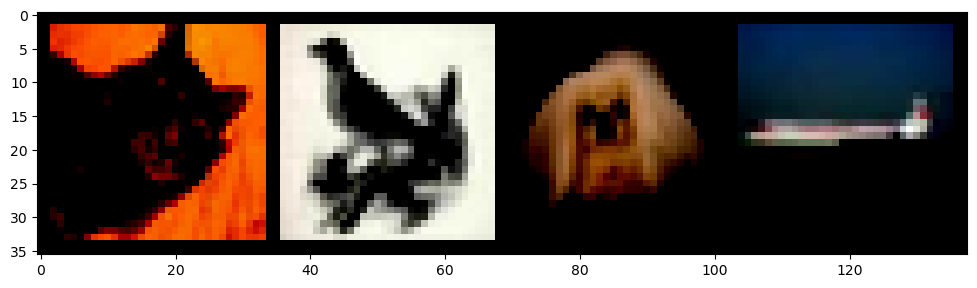

In [3]:
# Create a grid 
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

## CNN model

In [4]:
class Test(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(400, 128) # Q8. Fill out the correct input dimensions 
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    print(f'Input shape: {x.shape}')
    out = self.conv1(x)
    print(f'After Conv1: {out.shape}')
    print(f'Padding: {self.conv1.padding}')
    out = self.pool(F.relu(out))
    print(f'After Pool1: {out.shape}')
    out = self.conv2(out)
    print(f'After Conv2: {out.shape}')
    out = self.pool(F.relu(out))
    print(f'After Pool2: {out.shape}')
    # Flatten it before fc1
    out = out.reshape(-1, 400) # Q8. Fill out the correct dimension after -1
    print(f'Before fc1: {out.shape}')
    out = self.fc1(out)
    out = self.relu(out)
    print(f'After fc1: {out.shape}')
    out = self.fc2(out)
    out = self.relu(out)
    print(f'After fc2: {out.shape}')
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    print(f'After fc3: {out.shape}')
    return out


model = Test().to(device)
# Let's view the softmax output
probs = nn.Softmax(dim=1)


# Q5. What do the three arguments of the first convolutional layer, conv1 represent (3,6,5)? 
# 3 : the number of input channels, since given image has 3 channels(RGB), the conv1 must have '3' on this argument 
# 6 : the number of filters, the output has a depth of number of filters because each filter produces one channel in the output.  
# 5 : the kernal size

# Q6. Explain the arguments of the second convolutional layer, conv2 (6, 16, 5) 
# 6 : the number of input channels
# 16 : the number of filters, the output has a depth of number of filters because each filter produces one channel in the output.  
# 5 : the kernal size

# Q7. Figure out the convolved image size after conv1
# Convolved image size = ((input_width - filter_size + 2 * padding) / stride) + 1
# convolved image size = ((32 - 5 + 2*1) / 1) + 1 = 30

# Q8. Figure out the input size to the first fcn layer and fill out the code above in init() and forward()
# The shape of output after conv1, pool, conv2, pool, relu layer is (4, 16, 5, 5).
# Since the second argument of reshape() specifies the total number of elements of feature image, in the tensor after reshaping to a 1D tensor,
# the answer is 16*5*5 = 400.

### Run through a sample batch

In [8]:
sample = next(iter(train_loader))

images, labels = sample

images = images.to(device)
labels = labels.to(device)

output = model(images)
print(f'Output shape: {output.shape}')
print(f'Softmax outputs:\n {probs(output)}')


# Q9. Explain the shape of the output after conv1
# torch.Size([4, 6, 28, 28])
# The batch size does not change. Because the batch size of the given image is 4, it remains the same.
# The output has a depth of 'num_filters'=6 because each filter produces one channel in the output. 
# The height and width of the output are determined by the size of the filter (5x5), 
# the padding used (if any), and the stride used (in this case, stride=1). Using the formula 
# output image size = ((W - F + 2P) / S) + 1 as explained in the previous question, the output would have a size of 28x28.

# Q10. What does the pooling do to the dimensions of the feature images here?
# Since MaxPool2d with a pool size of 2x2 and stride of 2 is used, 
# the height and width of the output feature maps are half of the height and width of the input feature images, respectively.

# Pooling operates on each channel of the input feature maps separately, taking the maximum value over a local neighborhood of pixels. 
# This reduces the spatial resolution of the feature maps, while preserving the most salient features. 
# This can help to reduce overfitting and improve computational efficiency of NN model.

# Q11. Add padding=1 to conv1 and rerun the last two code cells. How did padding affect the dimensions of the feature images?
# output image size = ((W - F + 2P) / S) + 1
# After the conv1, the shape of output : torch.Size([4, 6, 30, 30])
# ((32-5+2)/1)+1 = 30, the height and width of feature images increased than before

# Q12. What is represented by each list returned by Softmax outputs?
# The output of the Softmax function is a probability distribution over the classes in classification probelem.
# Since there are 10 classes, it was returned in the form of a 2D tensor with a size(4*10) 
# indicating the logit value corresponding to each class of images in the batch, respectively.


Output shape: torch.Size([4, 10])
Softmax outputs:
 tensor([[8.0758e-01, 7.3856e-03, 7.6887e-02, 4.0760e-03, 1.3486e-02, 2.2135e-03,
         8.1445e-05, 8.0920e-02, 6.0576e-03, 1.3131e-03],
        [1.8116e-03, 4.4795e-04, 2.7097e-02, 2.8127e-01, 1.0087e-01, 5.5771e-01,
         1.9485e-02, 9.9171e-03, 1.1498e-03, 2.4194e-04],
        [1.6491e-03, 2.4200e-04, 3.2177e-01, 4.4972e-02, 1.0562e-01, 4.6018e-01,
         7.5634e-03, 5.6119e-02, 1.2196e-03, 6.6326e-04],
        [3.5809e-02, 1.6886e-02, 4.8371e-02, 5.6453e-02, 3.4027e-01, 8.1828e-02,
         1.1997e-02, 2.8365e-01, 3.4306e-02, 9.0436e-02]],
       grad_fn=<SoftmaxBackward0>)



### Let's Train!
- Now that we know and understand how CNNs work, let's put everything together for CIFAR-10 dataset
  - Download the data in batches and normalisation with shuffling
  - Build a model with 2 CNN layers containing ReLU and pooling
  - Passing the feature images to 3 fully connected layers (FCNs) also containing RELU activation
  - The final layer has 10 units to reprsent the number of output classes
  - Use Binary Cross Entropy Loss and SGD optimiser
  - Evaluate the model on the test data on EACH class

**IMPORTANT!** Fill out the missing code below before training 

In [9]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(400, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 400) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    return out


model = CNN().to(device)

# Q13. Use the Cross Entropy Loss for this task (UNCOMMENT & COMPLETE CODE BELOW)
criterion = nn.CrossEntropyLoss()

# Q14. Use the Stochastic Gradient Descent (SGD) optimiser, this time ADD momentum=0.9 (UNCOMMENT & COMPLETE CODE BELOW)
import torch.optim as optim
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


## Training loop

In [7]:
n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    #print(images.shape) # [4,3,32,32] batch size, channels, img dim
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and Optimise
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Print
    if (i+1) % 1000 == 0:
      print(f'Epoch {epoch+1}/{num_epochs}, Iteration {i+1}/{n_iterations}, Loss={loss.item():.4f} ')



Epoch 1/4, Iteration 1000/12500, Loss=2.3370 
Epoch 1/4, Iteration 2000/12500, Loss=1.9753 
Epoch 1/4, Iteration 3000/12500, Loss=2.0315 
Epoch 1/4, Iteration 4000/12500, Loss=1.7766 
Epoch 1/4, Iteration 5000/12500, Loss=1.0002 
Epoch 1/4, Iteration 6000/12500, Loss=1.2944 
Epoch 1/4, Iteration 7000/12500, Loss=1.4550 
Epoch 1/4, Iteration 8000/12500, Loss=1.0454 
Epoch 1/4, Iteration 9000/12500, Loss=1.5537 
Epoch 1/4, Iteration 10000/12500, Loss=1.1972 
Epoch 1/4, Iteration 11000/12500, Loss=0.7386 
Epoch 1/4, Iteration 12000/12500, Loss=2.5292 
Epoch 2/4, Iteration 1000/12500, Loss=0.7618 
Epoch 2/4, Iteration 2000/12500, Loss=1.1494 
Epoch 2/4, Iteration 3000/12500, Loss=1.4192 
Epoch 2/4, Iteration 4000/12500, Loss=1.1864 
Epoch 2/4, Iteration 5000/12500, Loss=1.3398 
Epoch 2/4, Iteration 6000/12500, Loss=1.1420 
Epoch 2/4, Iteration 7000/12500, Loss=0.3626 
Epoch 2/4, Iteration 8000/12500, Loss=0.9433 
Epoch 2/4, Iteration 9000/12500, Loss=0.8705 
Epoch 2/4, Iteration 10000/1250

## Evaluation

In [10]:
# Deactivate the autograd engine to reduce memory usage and speed up computations (backprop disabled).
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]


  # Loop through test set
  for images, labels in test_loader:
    # Put images on GPU
    images = images.to(device)
    labels = labels.to(device)
    # Run on trained model
    outputs = model(images) 

    # Get predictions
    # torch.max() returns actual probability value (ignored) and index or class label (selected)
    _, y_preds = torch.max(outputs, 1)
    n_samples += labels.size(0) # different to FFNN
    n_correct += (y_preds == labels).sum().item()

    # Keep track of each class
    for i in range(batch_size):
      label = labels[i]
      pred = y_preds[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  # Print accuracy
  acc = 100.0 * n_correct / n_samples
  print(f'Test Accuracy of the WHOLE CNN = {acc} %')

  for i in range(len(classes)):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')


Test Accuracy of the WHOLE CNN = 10.0 %
Accuracy of plane: 0.0 %
Accuracy of car: 0.0 %
Accuracy of bird: 0.0 %
Accuracy of cat: 0.0 %
Accuracy of deer: 100.0 %
Accuracy of dog: 0.0 %
Accuracy of frog: 0.0 %
Accuracy of horse: 0.0 %
Accuracy of ship: 0.0 %
Accuracy of truck: 0.0 %


In [ ]:
# Q15. Why don't we need to reshape the input images when training and testing?
# In PyTorch, Convolutional layers are designed to work with input images of any size. 
# When we define a convolutional layer, we specify the size of the filters and the stride, 
# and the layer automatically computes the output size of the convolutional operation based on the size of the input image.
# This means that we can use images of different sizes during training and testing, as long as they have the same number of channels (e.g., RGB images have 3 channels). 

# Q16. Try to improve the model performance, e.g. by increasing the epochs, changing batch size, adding convolutions, etc.
# Provide the code chunk showing the improved accuracy on the test set below. What changes did you make?

In [8]:
import torch.optim as optim
batch_size = 8 # increased the batch size to get faster results
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_set = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    # flatten 3D tensor to 1D tensor
    self.fc1 = nn.Linear(400, 128) # TODO
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10) # final output matches num_classes

  def forward(self, x):
    # Conv + ReLU + pool
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    # Flatten it before fc1
    out = out.reshape(-1, 400) # TODO
    out = F.relu(self.fc1(out))
    out = F.relu(self.fc2(out))
    out = self.fc3(out) # NO softmax as it will be included in CrossEntropyLoss
    return out

# optimizing number of epochs.
num_epochs_list = [6, 10, 14, 18]
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

n_total_steps = len(train_set)
n_iterations = -(-n_total_steps // batch_size) # ceiling division

for num_epochs in num_epochs_list:
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and Optimise
            opt.zero_grad()
            loss.backward()
            opt.step()

    with torch.no_grad():
        n_correct = 0   
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]


    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) 
        _, y_preds = torch.max(outputs, 1)
        n_samples += labels.size(0) 
        n_correct += (y_preds == labels).sum().item()
        for i in range(batch_size):
            label = labels[i]
            pred = y_preds[i]
        if (label == pred):
            n_class_correct[label] += 1
        n_class_samples[label] += 1

    # Print accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Test Accuracy of the WHOLE CNN = {acc} %')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Files already downloaded and verified
Files already downloaded and verified
Test Accuracy of the WHOLE CNN = 62.82 %
Accuracy of plane: 74.59016393442623 %
Accuracy of car: 75.38461538461539 %
Accuracy of bird: 56.36363636363637 %
Accuracy of cat: 45.689655172413794 %
Accuracy of deer: 53.125 %
Accuracy of dog: 56.89655172413793 %
Accuracy of frog: 72.53521126760563 %
Accuracy of horse: 61.940298507462686 %
Accuracy of ship: 75.53956834532374 %
Accuracy of truck: 72.56637168141593 %
Test Accuracy of the WHOLE CNN = 63.98 %
Accuracy of plane: 67.21311475409836 %
Accuracy of car: 84.61538461538461 %
Accuracy of bird: 41.81818181818182 %
Accuracy of cat: 38.793103448275865 %
Accuracy of deer: 68.75 %
Accuracy of dog: 71.55172413793103 %
Accuracy of frog: 79.5774647887324 %
Accuracy of horse: 69.40298507462687 %
Accuracy of ship: 74.10071942446044 %
Accuracy of truck: 70.79646017699115 %
Test Accuracy of the WHOLE CNN = 62.48 %
Accuracy of plane: 66.39344262295081 %
Accuracy of car: 83.076

In [ ]:
# It showed the best performance when the number of epochs was 10.